In [19]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.mixture import BayesianGaussianMixture

In [20]:

# Load the data
file_path = "dataset/agriculture_dataset.csv"
df = pd.read_csv(file_path)


In [21]:
# Define the function to handle missing values
def handle_missing_values(data, column, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    data[[column]] = imputer.fit_transform(data[[column]])
    return data

# Define the function for IQR outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[f'iqr_outlier'] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), -1, 1)
    return data

# Define the function for Z-Score outlier detection
def detect_outliers_zscore(data, column, threshold=3):
    data['zscore'] = (data[column] - data[column].mean()) / data[column].std()
    data[f'zscore_outlier'] = np.where(np.abs(data['zscore']) > threshold, -1, 1)
    data.drop(columns=['zscore'], inplace=True)
    return data

# Define the function for Isolation Forest outlier detection
def detect_outliers_isolation_forest(data, column):
    iso_forest = IsolationForest(contamination=0.05)
    labels = iso_forest.fit_predict(data[[column]])
    data[f'if_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for DBSCAN outlier detection
def detect_outliers_dbscan(data, column):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column]])
    dbscan = DBSCAN(eps=0.3, min_samples=10)
    labels = dbscan.fit_predict(scaled_data)
    data[f'dbscan_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for One-Class SVM outlier detection
def detect_outliers_one_class_svm(data, column):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column]])
    svm = OneClassSVM(nu=0.05)
    labels = svm.fit_predict(scaled_data)
    data[f'ocsvm_outlier'] = np.where(labels == -1, -1, 1)
    return data

# Define the function for Local Outlier Factor (LOF) outlier detection
def detect_outliers_lof(data, column):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    labels = lof.fit_predict(data[[column]])
    data[f'lof_outlier'] = np.where(labels == -1, -1, 1)
    return data


# Define the function for Gaussian Naive Bayes outlier detection using the Gaussian PDF
def detect_outliers_gaussian(data, column, threshold=0.01):
    # Calculate the mean and standard deviation of the column
    mean = data[column].mean()
    std_dev = data[column].std()
    
    # Calculate the probability density for each point
    pdf_values = norm.pdf(data[column], mean, std_dev)
    
    # Label outliers as -1 if their probability density is below the threshold
    data[f'gaussianpdf_outlier'] = np.where(pdf_values < threshold, -1, 1)
    
    return data


In [22]:
from sklearn.preprocessing import StandardScaler

# Function to standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)


In [23]:
# Function to classify outliers using Gaussian Naive Bayes
def detect_outliers_gnb(data, column='N2O'):
    gnb = GaussianNB()
    X = data.drop(columns=[column])
    y = data[column]
    
    # Train the model
    gnb.fit(X, y)
    
    # Predict the outliers
    y_pred = gnb.predict(X)
    
    # Classify as -1 for outlier, 1 for inlier based on the model prediction
    outlier_labels = np.where(y_pred == y.min(), -1, 1)  # Adjust the threshold as needed
    
    # Add the outlier labels to the original data
    data['gnb_outlier'] = outlier_labels
    return data

In [24]:
def detect_outliers_gaussian_nb(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # First, use Isolation Forest to create an initial set of outlier labels
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_outliers = iso_forest.fit_predict(X)
    
    # Map the Isolation Forest labels to binary labels: 1 for inliers, -1 for outliers
    binary_outliers = np.where(iso_outliers == 1, 1, -1)
    
    # Train GaussianNB using the binary outlier labels
    nb_model = GaussianNB()
    nb_model.fit(X, binary_outliers)
    
    # Predict outliers (-1 for outliers, 1 for inliers) using GaussianNB
    outlier_labels = nb_model.predict(X)
    
    # Add outlier labels to the original dataframe
    data['gaussian_nb_outlier'] = outlier_labels
    return data

In [25]:


# Define the function for Bayesian Gaussian Mixture Model (BGM) outlier detection
def detect_outliers_bayesian_gmm(data, column, n_components=2):
    bgm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    bgm.fit(data[[column]])
    log_probs = bgm.score_samples(data[[column]])
    data[f'bgm_outlier'] = np.where(log_probs < np.percentile(log_probs, 5), -1, 1)
    return data

In [26]:

# Apply the missing value handler

data = handle_missing_values(df, 'N2O', strategy='mean')


In [32]:

# Apply each outlier detection method
data = detect_outliers_iqr(data, 'N2O')
data = detect_outliers_zscore(data, 'N2O')
data = detect_outliers_isolation_forest(data, 'N2O')
data = detect_outliers_dbscan(data, 'N2O')
data = detect_outliers_one_class_svm(data, 'N2O')
data = detect_outliers_lof(data, 'N2O')
data = detect_outliers_gaussian(data, 'N2O')
# data = detect_outliers_gnb(data, 'N2O')



In [34]:
# data = detect_outliers_gaussian_nb(data, 'N2O')
# data = detect_outliers_gaussian_nb(data, 'N2O')
data = detect_outliers_bayesian_gmm(data, 'N2O')

In [31]:
data

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,Sand,SOM,iqr_outlier,zscore_outlier,if_outlier,dbscan_outlier,ocsvm_outlier,lof_outlier,gaussianpdf_outlier,bgm_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,637.500000,1.174072,1,1,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,637.500000,1.174072,1,1,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,637.500000,1.174072,1,1,1,1,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,637.500000,1.174072,1,1,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,637.500000,1.174072,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,491.666667,1.806000,1,1,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,490.375000,1.496400,1,1,1,1,1,1,1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,432.875000,1.186800,1,1,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,418.833333,1.823200,1,1,1,1,1,1,1,1


## Naive Bayes Classification Outlier

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Function to integrate Isolation Forest and LOF for outlier detection
def integrate_if_lof(data, column):
    # Normalize the feature
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[[column]])
    
    # Fit Isolation Forest and get outlier scores
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(X_scaled)
    if_probabilities = -iso_forest.decision_function(X_scaled)  # Higher scores for outliers

    # Fit LOF and get outlier scores
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_scores = -lof.fit_predict(X_scaled)  # Higher scores for outliers
    lof_scores = lof.negative_outlier_factor_

    # Integrate scores
    integrated_scores = (if_probabilities + lof_scores) / 2

    return X_scaled, integrated_scores

# Function to classify outliers using Naive Bayes
def classify_outliers_naive_bayes(data, column, threshold_percentile=90):
    # Handle missing values
    data = handle_missing_values(data, column, strategy='mean')
    
    # Integrate IF and LOF scores
    X_scaled, integrated_scores = integrate_if_lof(data, column)
    
    # Determine threshold for outliers
    threshold = np.percentile(integrated_scores, threshold_percentile)
    
    # Binary labels for Naive Bayes (1 for inliers, -1 for outliers)
    labels = np.where(integrated_scores > threshold, -1, 1)
    
    # Split data for training and testing
    X_train, X_test, labels_train, labels_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)
    
    # Train GaussianNB model for outlier classification
    nb_model = GaussianNB()
    nb_model.fit(X_train, labels_train)
    
    # Predict outliers on the full dataset
    data['nb_outlier'] = nb_model.predict(X_scaled)
    
    return data

In [37]:
data = classify_outliers_naive_bayes(data, 'N2O')

In [38]:
data

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,SOM,iqr_outlier,zscore_outlier,if_outlier,dbscan_outlier,ocsvm_outlier,lof_outlier,gaussianpdf_outlier,bgm_outlier,nb_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,1.174072,1,1,1,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,1.174072,1,1,1,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,1.174072,1,1,1,1,1,1,1,1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,1.174072,1,1,1,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,1.174072,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,1.806000,1,1,1,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,1.496400,1,1,1,1,1,1,1,1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,1.186800,1,1,1,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,1.823200,1,1,1,1,1,1,1,1,1


In [ ]:

# Display the updated data with outlier column
# data = detect_outliers_hbos(data, 'N2O')
# data = detect_outliers_cblof(data, 'N2O')
# data = detect_outliers_mahalanobis(data, 'N2O')


In [39]:
data.to_csv('hasil/0905_2_N2O_Agriculture_OutlierDetection_5_Update09062024.csv', index=False)

In [ ]:
data

In [42]:
# Summarize the count of outliers and inliers for each method

def summarize_outliers(df, method_columns):
    summary = []
    for column in method_columns:
        inliers = df[column].value_counts().get(1, 0)
        outliers = df[column].value_counts().get(-1, 0) if df[column].min() == -1 else df[column].value_counts().get(0, 0)
        total = len(df[column])
        summary.append({
            'Method': column.replace('_outlier', ''),
            'Outliers': outliers,
            'Inliers': inliers,
            'Total': total
        })
    return pd.DataFrame(summary)

# List of outlier detection columns
outlier_columns = [col for col in df.columns if col.endswith('_outlier')]

# Generate the summary
summary_df = summarize_outliers(df, outlier_columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Detection Summary", dataframe=summary_df)

summary_df


,Method,Outliers,Inliers,Total
0,iqr,251,1995,2246
1,zscore,32,2214,2246
2,if,113,2133,2246
3,dbscan,37,2209,2246
4,ocsvm,112,2134,2246
5,lof,113,2133,2246
6,gaussianpdf,87,2159,2246
7,bgm,113,2133,2246
8,nb,42,2204,2246


In [43]:
summary_df.to_csv('hasil/0905_2_N2O_Agriculture_OutlierDetection_5_Update09062024_Summary.csv', index=False)

In [45]:
# Define a function to summarize the count of inliers and outliers for each method
def summarize_outliers(data, methods):
    summary = []
    for method in methods:
        inliers = (data[f'{method}_outlier'] == 1).sum()
        outliers = (data[f'{method}_outlier'] == -1).sum()
        total = inliers + outliers
        summary.append({'Method': method, 'Inliers': inliers, 'Outliers': outliers, 'Total': total})
    return pd.DataFrame(summary)

# List of methods used for outlier detection
methods = ['iqr', 'zscore','if', 'dbscan', 'ocsvm', 'lof','gaussianpdf','bgm','nb']

# Generate the summary
summary_df = summarize_outliers(data, methods)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Detection Summary", dataframe=summary_df)

summary_df


,Method,Inliers,Outliers,Total
0,iqr,1995,251,2246
1,zscore,2214,32,2246
2,if,2133,113,2246
3,dbscan,2209,37,2246
4,ocsvm,2134,112,2246
5,lof,2133,113,2246
6,gaussianpdf,2159,87,2246
7,bgm,2133,113,2246
8,nb,2204,42,2246


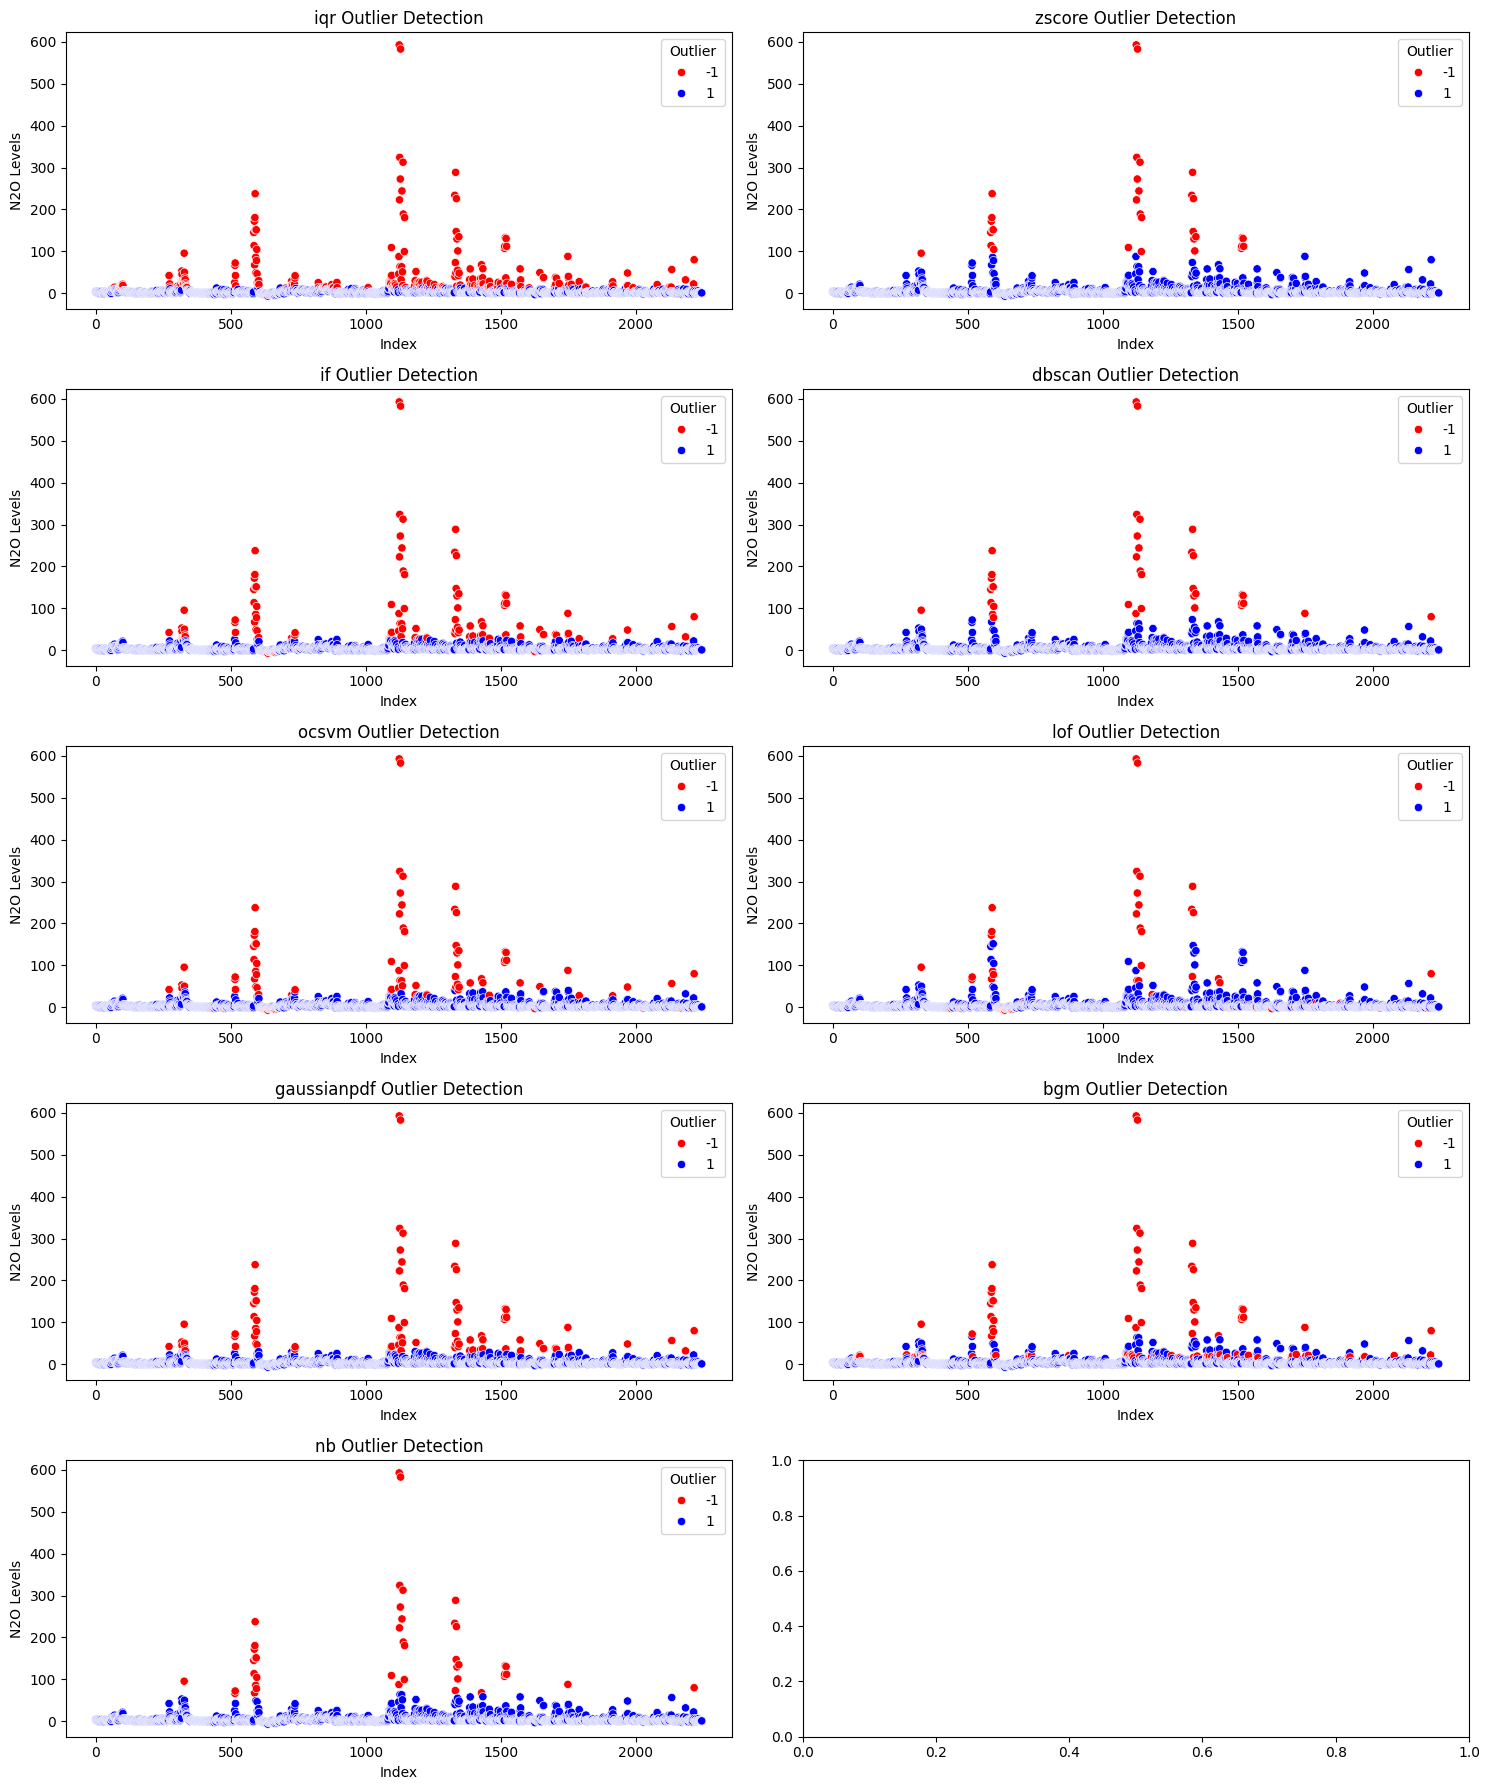

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure layout
fig, axes = plt.subplots(5, 2, figsize=(15, 18))

# List of methods for outlier detection
# methods = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF', 'NaiveBayes']
# methods = ['IQR', 'ZScore','IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes','IF_LOF','IF_Gaussian_LOF','IF_DBSCAN_SVM']
methods = ['iqr', 'zscore','if', 'dbscan', 'ocsvm', 'lof','gaussianpdf','bgm','nb']

# Define a function to plot outliers for each method
def plot_outliers(data, method, ax):
    sns.scatterplot(x=data.index, y=data['N2O'], hue=data[f'{method}_outlier'], palette={1: 'blue', -1: 'red'}, ax=ax)
    ax.set_title(f'{method} Outlier Detection')
    ax.set_xlabel('Index')
    ax.set_ylabel('N2O Levels')
    ax.legend(title='Outlier', loc='upper right')

# Create a plot for each method
for i, method in enumerate(methods[:10]):
    plot_outliers(data, method, axes[i // 2, i % 2])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


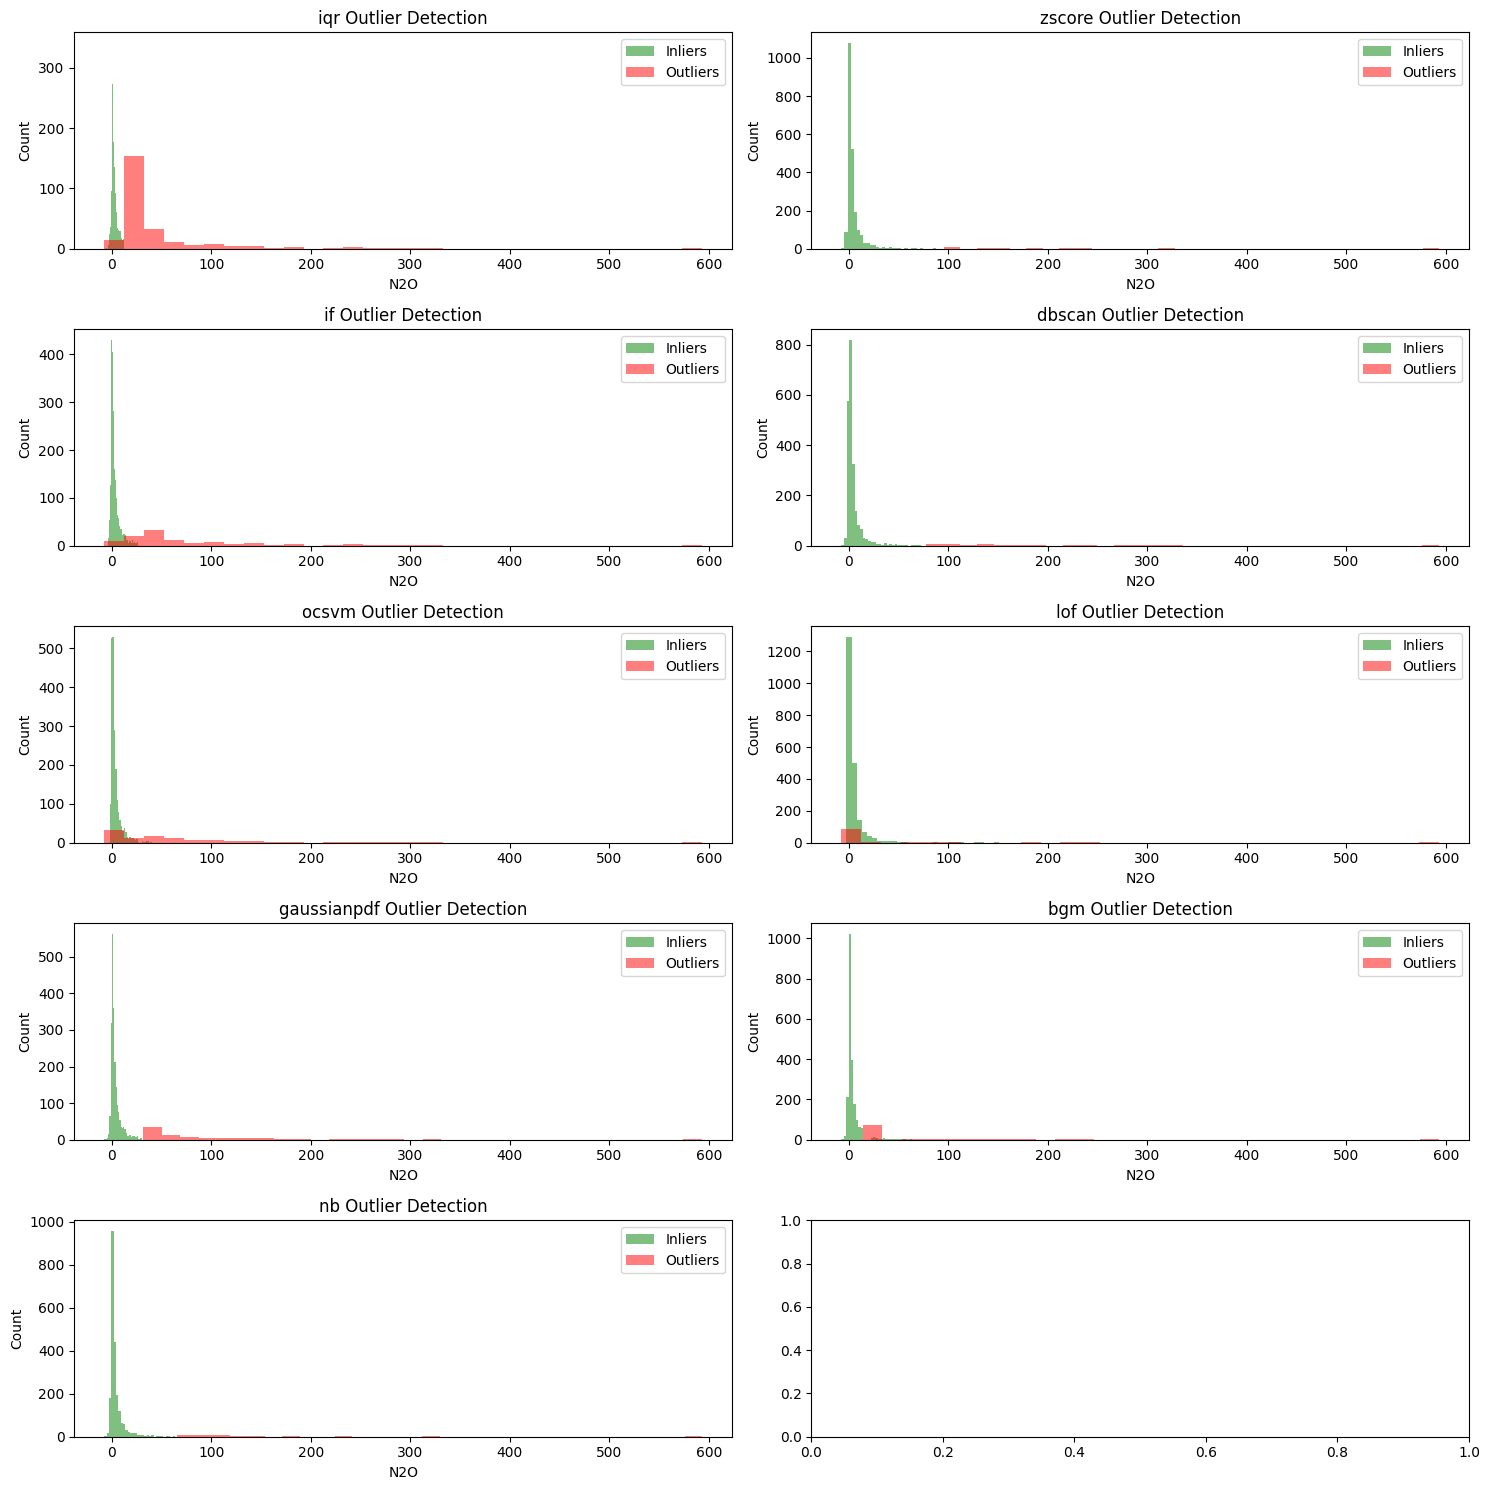

In [50]:
# Redefine the plotting code to handle the correct number of subplots (3 rows x 2 columns for 6 methods)
# Removing one of the methods from the plotting to fit the layout or handle separately

# List of methods used for outlier detection (reduced to 6 for fitting 3x2 layout)
# methods = ['IQR', 'ZScore', 'IQR_ZScore', 'IF', 'DBSCAN', 'OneClassSVM', 'LOF','NaiveBayes']
# List of methods used for outlier detection (reduced to 6 for fitting 3x2 layout)
methods = ['iqr', 'zscore','if', 'dbscan', 'ocsvm', 'lof','gaussianpdf','bgm','nb']

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each method
for i, method in enumerate(methods):
    ax = axes[i]
    inliers = data[data[f'{method}_outlier'] == 1]['N2O']
    outliers = data[data[f'{method}_outlier'] == -1]['N2O']
    
    ax.hist(inliers, bins=30, alpha=0.5, label='Inliers', color='green')
    ax.hist(outliers, bins=30, alpha=0.5, label='Outliers', color='red')
    ax.set_title(f'{method} Outlier Detection')
    ax.set_xlabel('N2O')
    ax.set_ylabel('Count')
    ax.legend()

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()


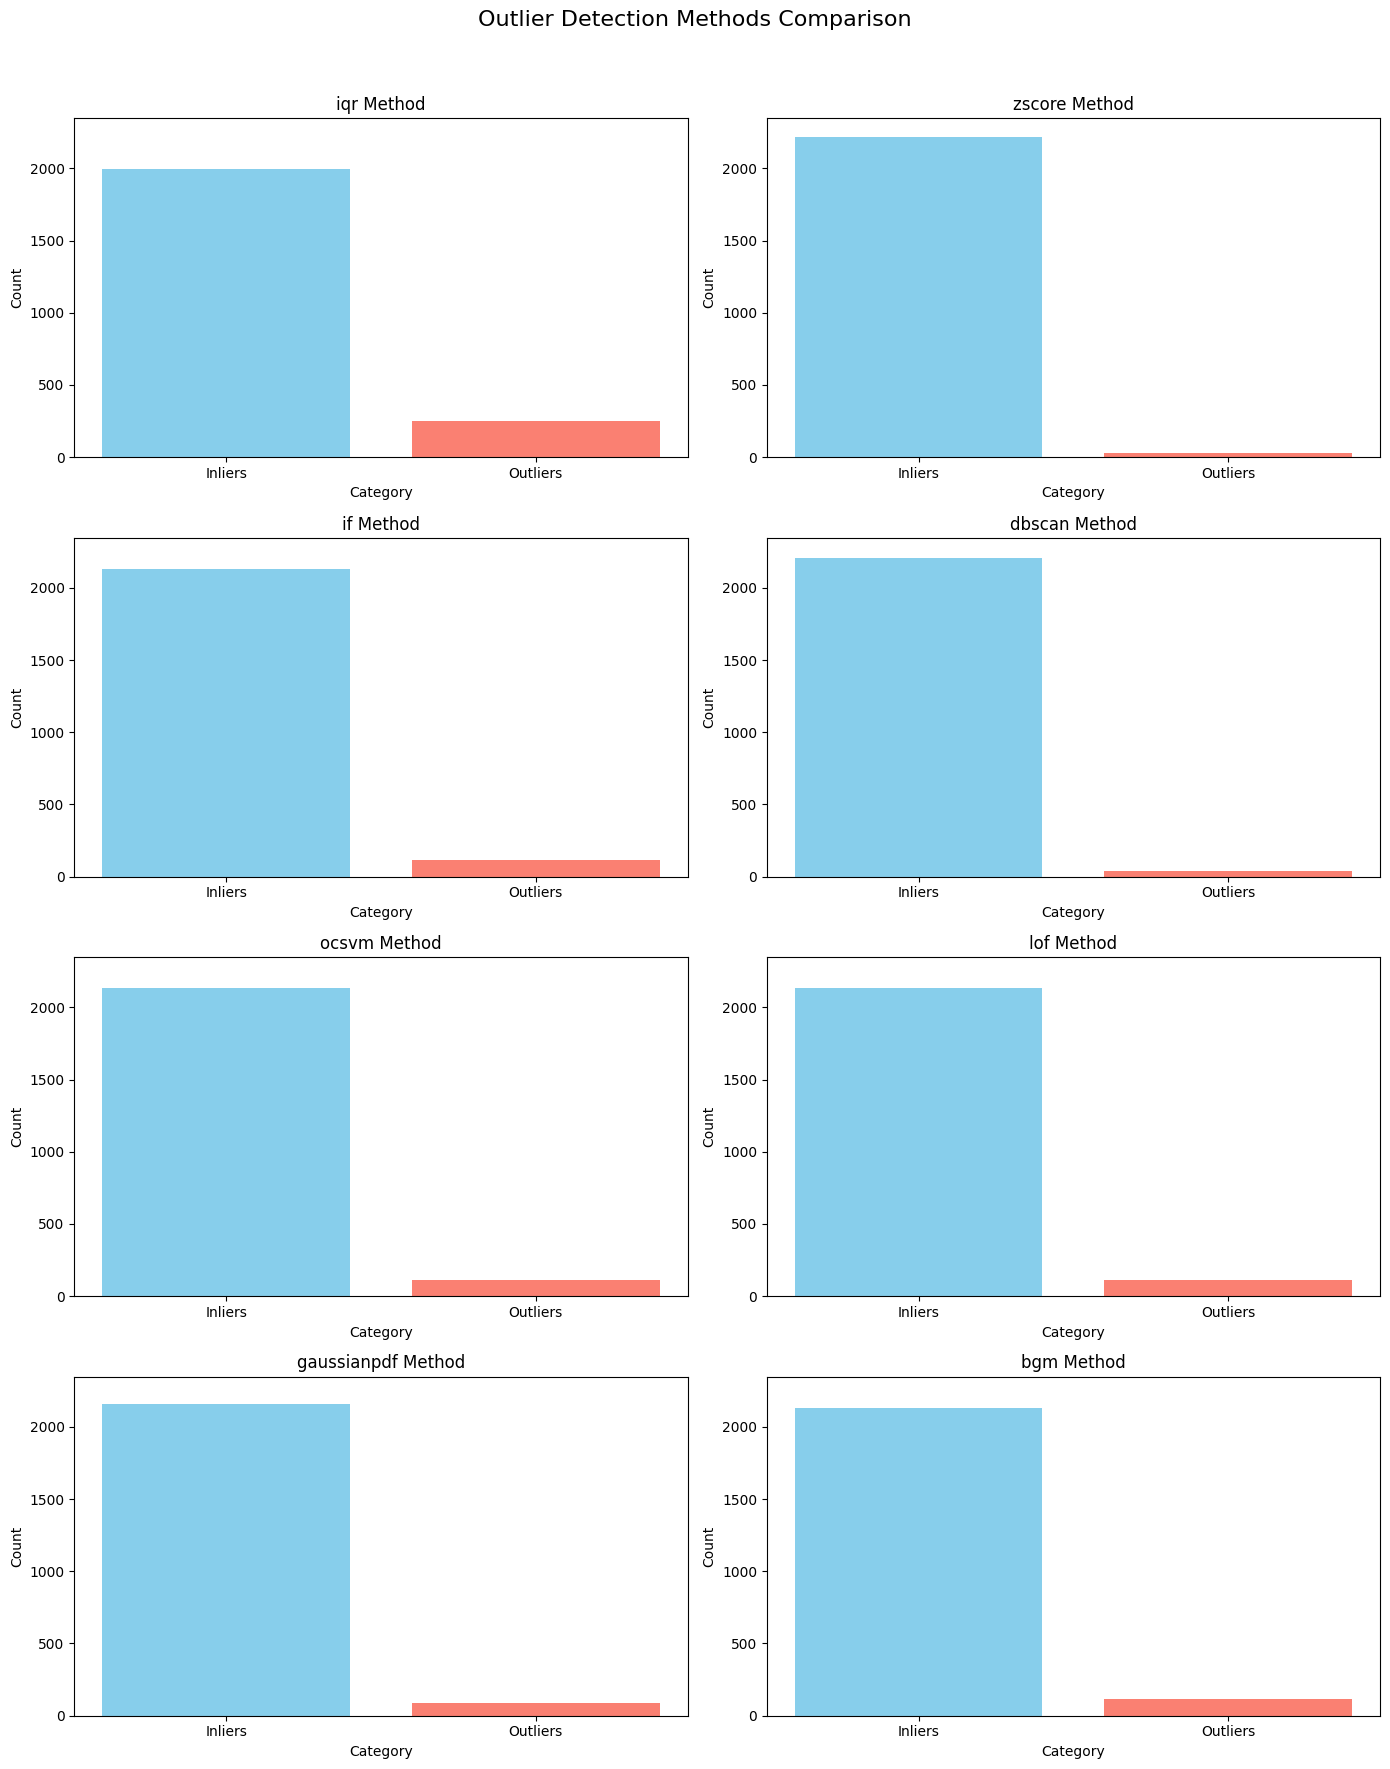

In [51]:
# To ensure proper indexing, we'll adjust the loop to match the correct number of subplots and handle exceptions.

def plot_outlier_comparison_final(summary_df):
    fig, axes = plt.subplots(4, 2, figsize=(14, 18))
    fig.suptitle('Outlier Detection Methods Comparison', fontsize=16)
    axes = axes.flatten()
    methods = summary_df['Method']

    # Plot each method
    for i, method in enumerate(methods):
        if i < len(axes):  # Ensure we don't access out-of-bound indexes
            axes[i].bar(['Inliers', 'Outliers'], summary_df.loc[i, ['Inliers', 'Outliers']], color=['skyblue', 'salmon'])
            axes[i].set_title(f'{method} Method')
            axes[i].set_xlabel('Category')
            axes[i].set_ylabel('Count')
            axes[i].set_ylim(0, summary_df['Total'].max() + 100)

    # Hide any unused subplots
    for j in range(len(methods), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize the comparison with the final corrected version
plot_outlier_comparison_final(summary_df)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17324\3551064160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17324\3551064160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17324\3551064160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17324\3551064160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

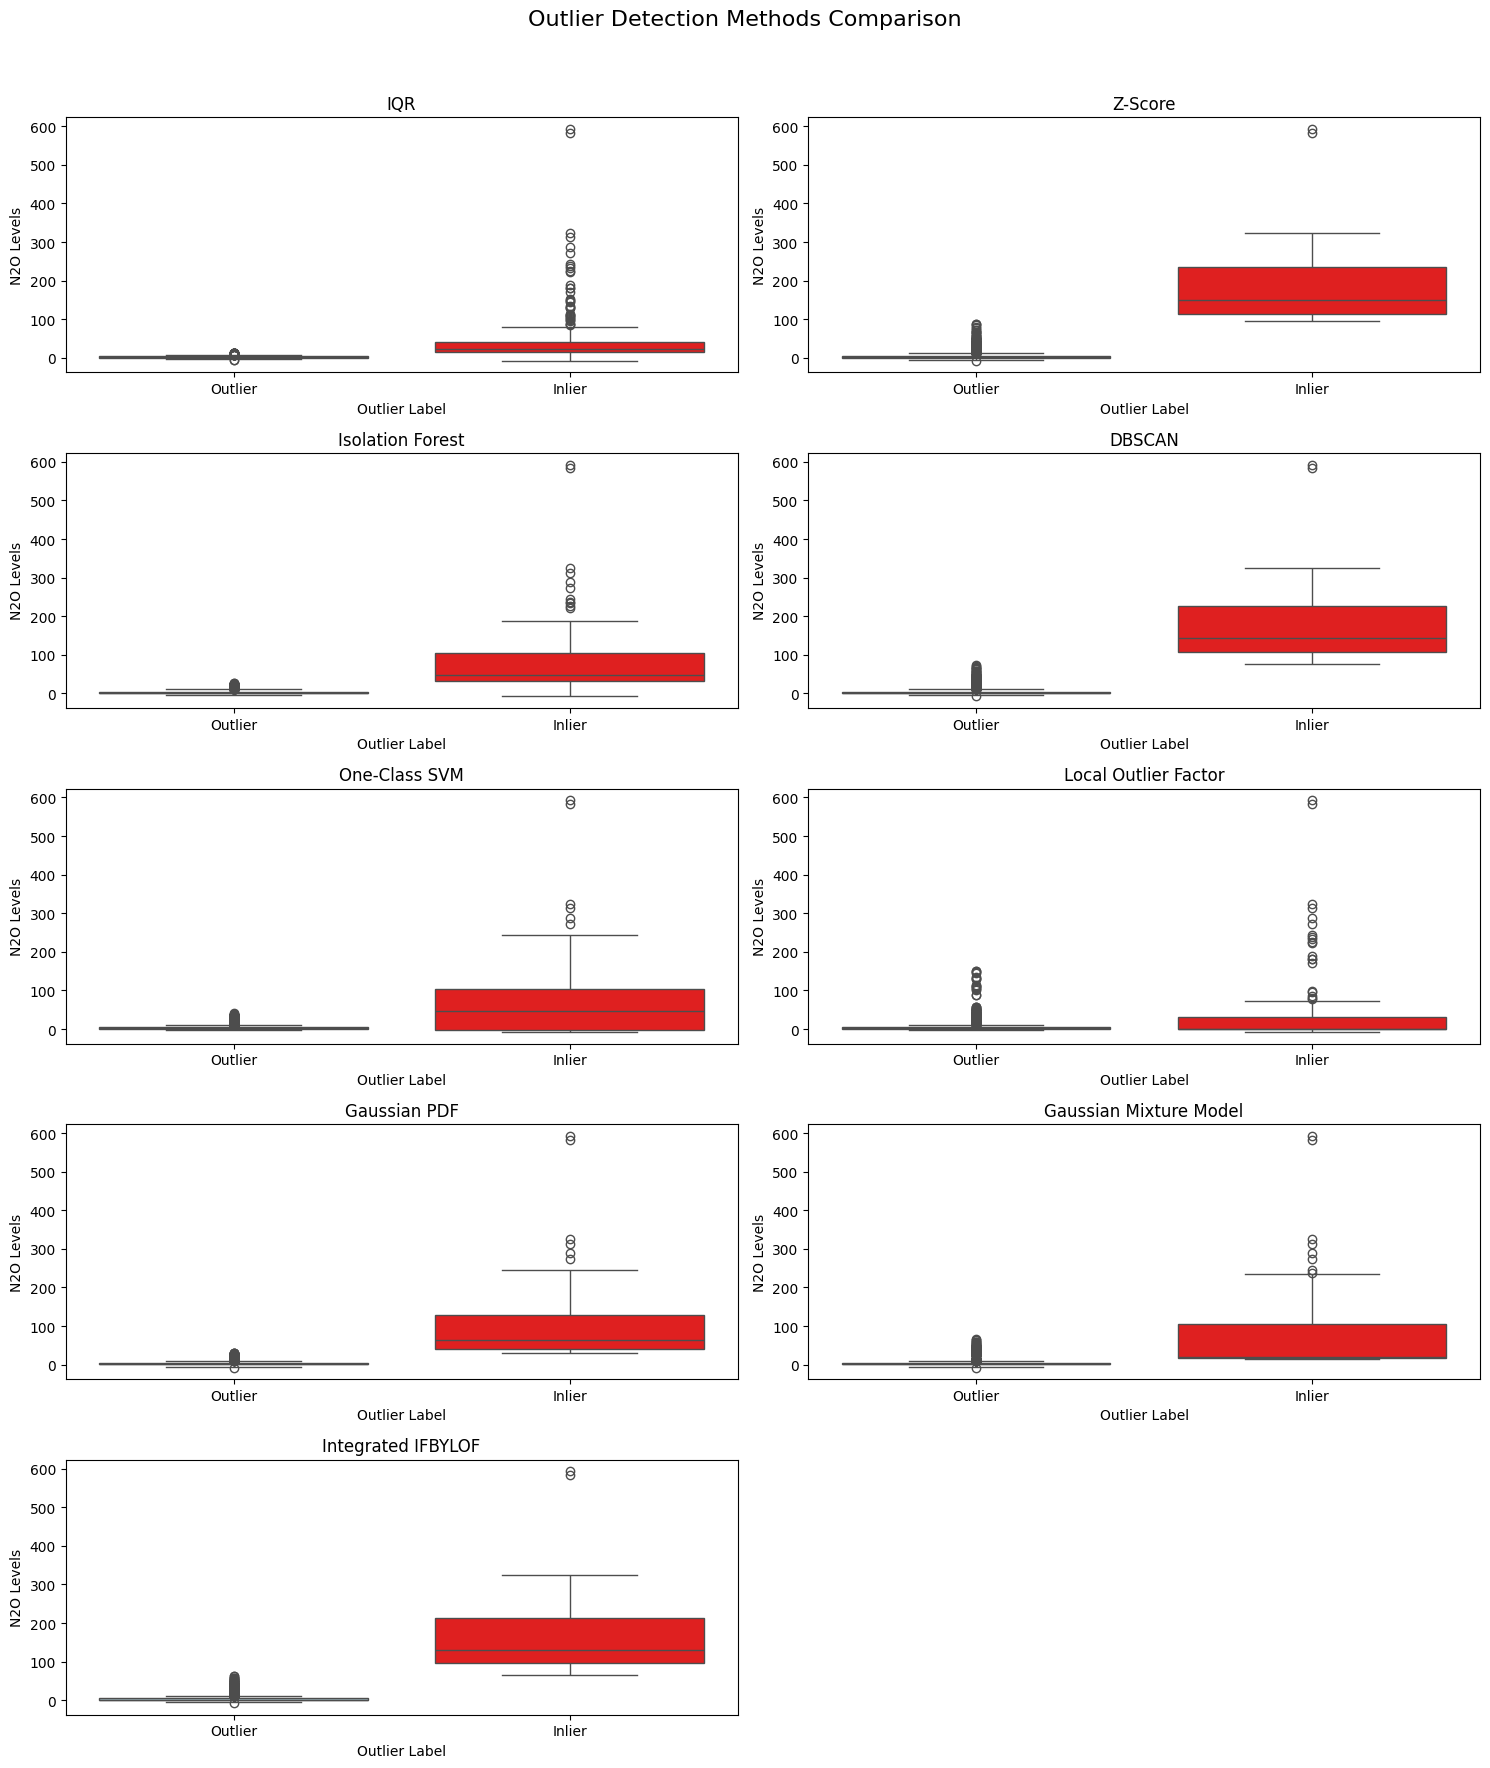

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the layout for the subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 18))
fig.suptitle('Outlier Detection Methods Comparison', fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Method list and their corresponding titles for the plots
methods = ['iqr', 'zscore', 'if', 'dbscan', 'ocsvm', 'lof','gaussianpdf','bgm','nb']
titles = ['IQR', 'Z-Score', 'Isolation Forest', 'DBSCAN', 'One-Class SVM', 'Local Outlier Factor','Gaussian PDF','Gaussian Mixture Model','Integrated IFBYLOF']

# Generate boxplots for each method
for i, method in enumerate(methods):
    if i < len(axes):
        sns.boxplot(
            x=data[f'{method}_outlier'].astype(str),  # Convert labels to strings for the palette
            y=data['N2O'], 
            ax=axes[i], 
            palette={'1': 'lightblue', '-1': 'red'}
        )
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Outlier Label')
        axes[i].set_ylabel('N2O Levels')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Outlier', 'Inlier'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


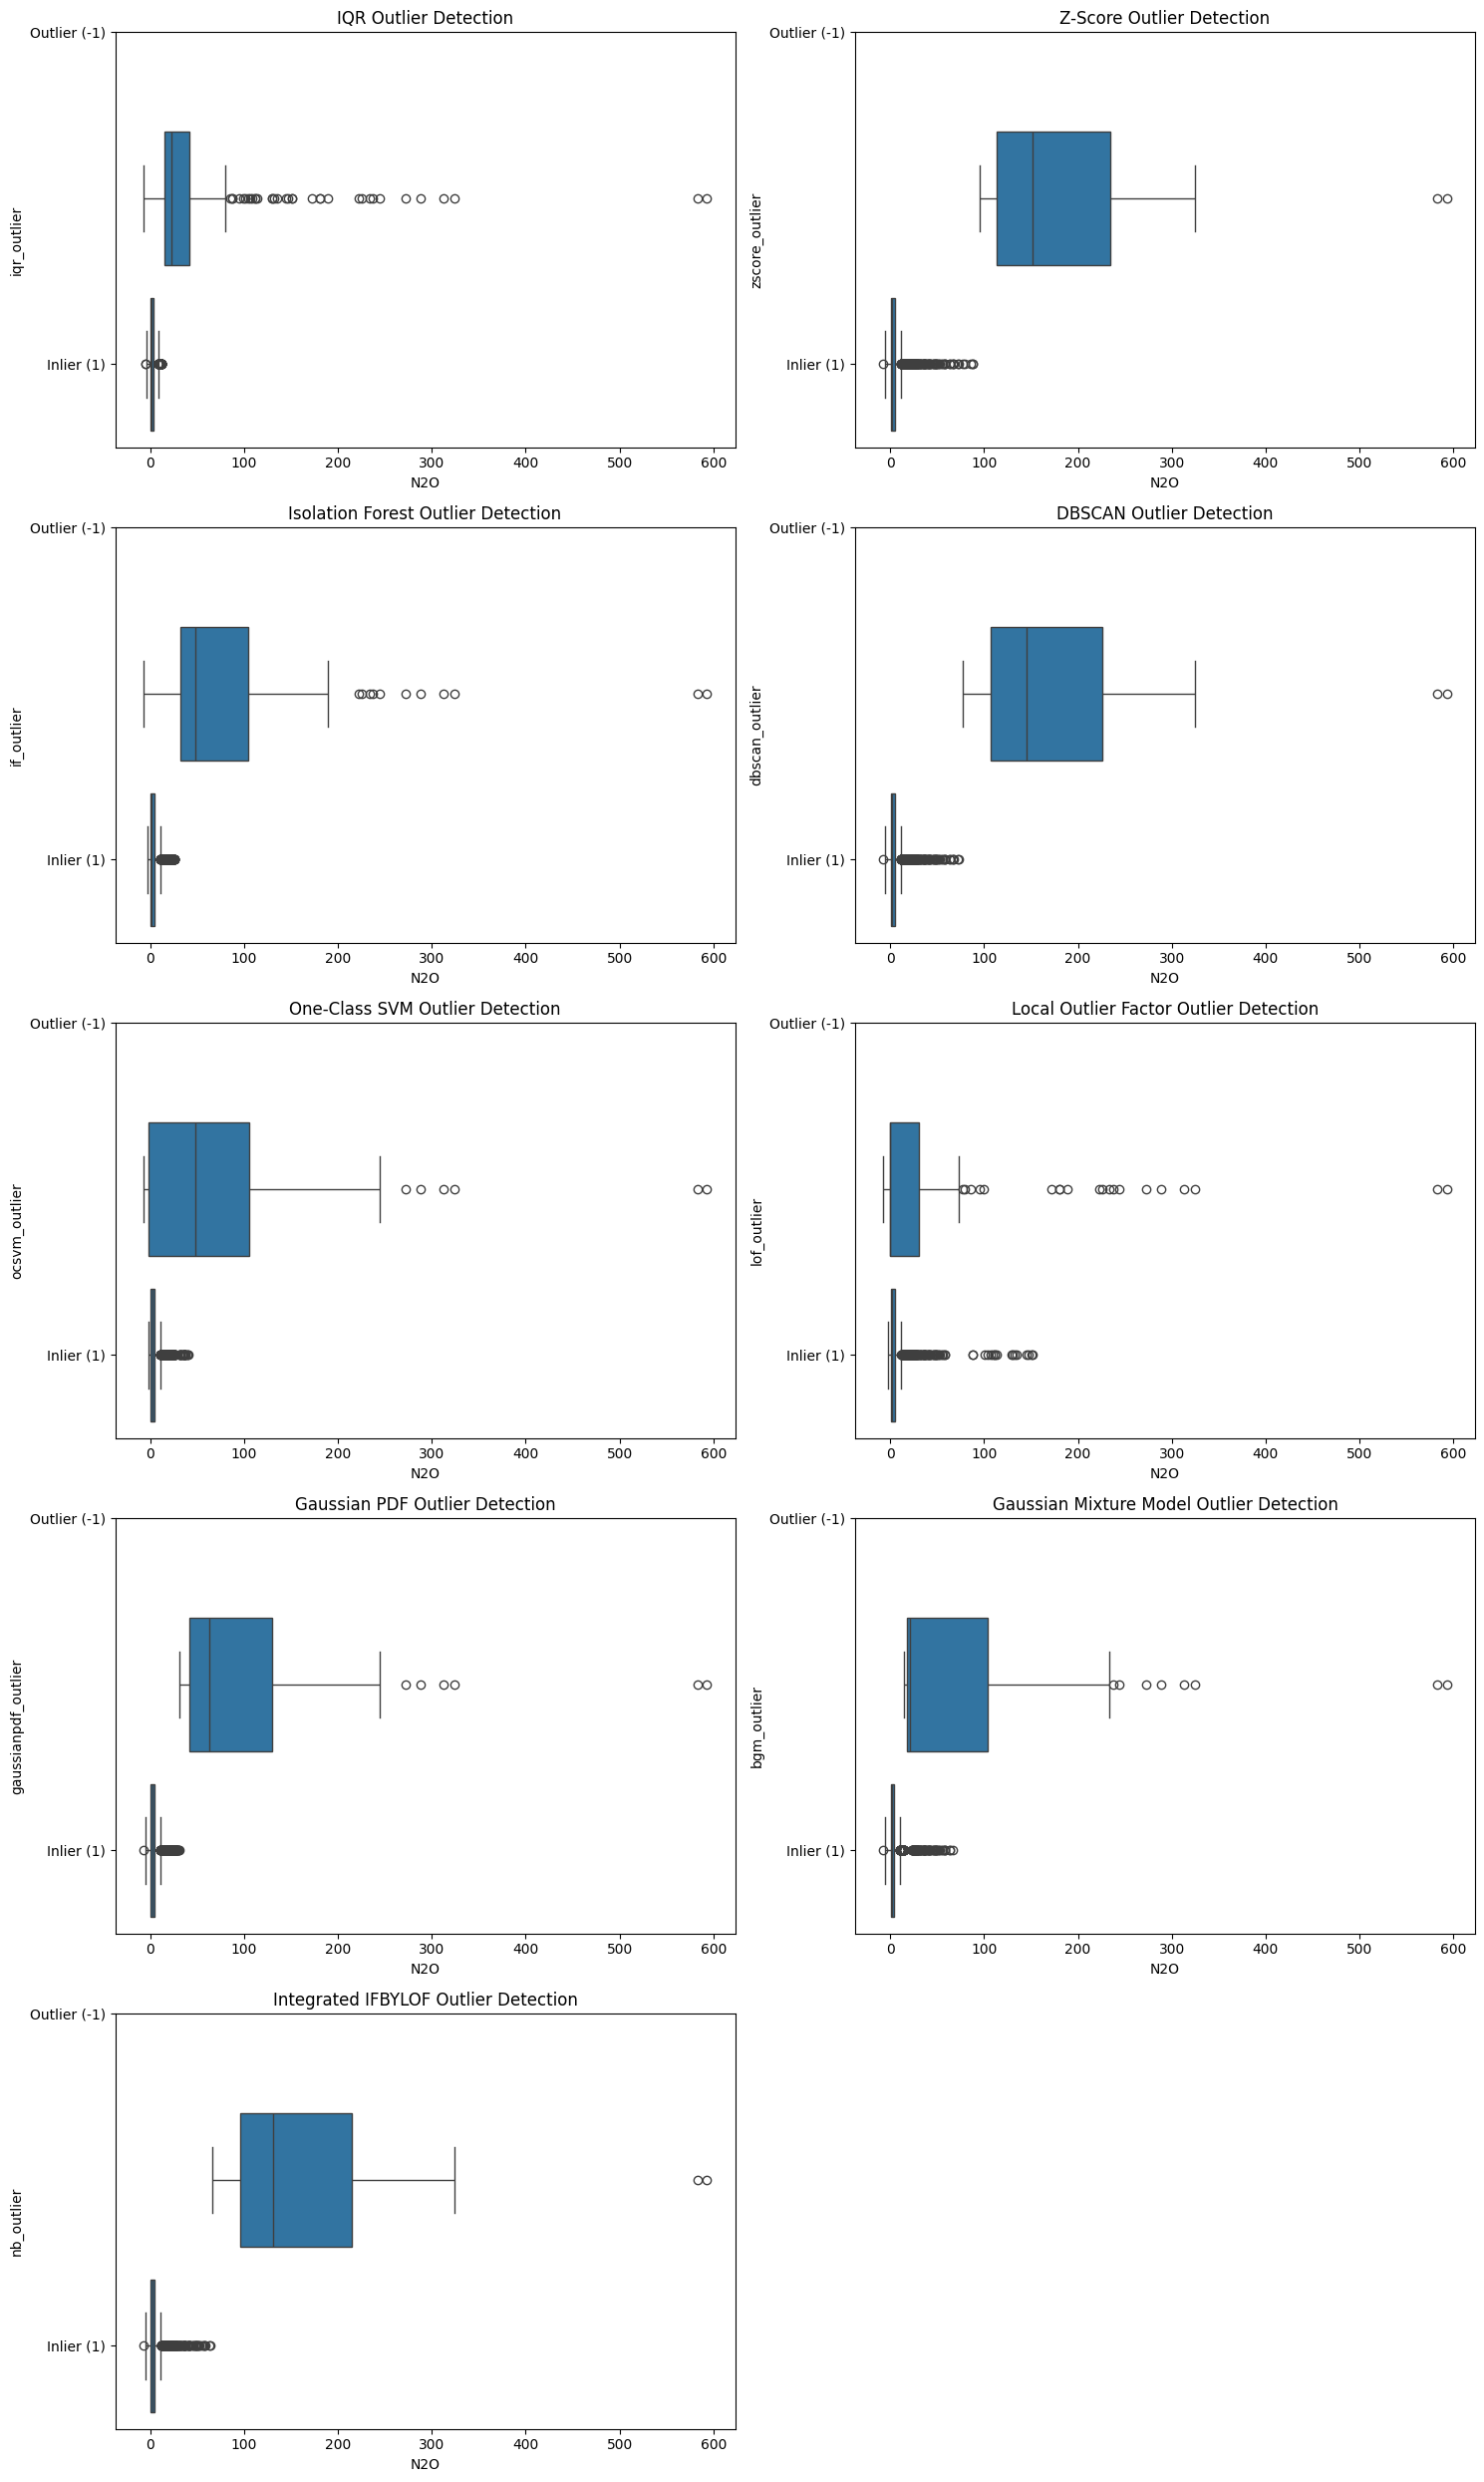

In [59]:
# Adjust the layout for 5 rows and 2 columns to accommodate all methods
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Method list and their corresponding titles for the plots
methods = ['iqr', 'zscore', 'if', 'dbscan', 'ocsvm', 'lof', 'gaussianpdf', 'bgm', 'nb']
titles = ['IQR', 'Z-Score', 'Isolation Forest', 'DBSCAN', 'One-Class SVM', 'Local Outlier Factor', 'Gaussian PDF', 'Gaussian Mixture Model', 'Integrated IFBYLOF']

# Example of how to plot IQR-based outliers (You will need to adapt similar functions for other methods)

# Function to plot each method's outliers
def plot_outliers(ax, method, title):
    sns.boxplot(x='N2O', y=f'{method}_outlier', data=data, ax=ax, orient='h')
    ax.set_title(f'{title} Outlier Detection')
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(['Outlier (-1)', 'Inlier (1)'])
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

# Plot each method's outliers
for i, method in enumerate(methods):
    row = i // 2
    col = i % 2
    plot_outliers(axes[row, col], method, titles[i])

# Hide the unused subplot if the number of methods is odd
if len(methods) % 2 != 0:
    fig.delaxes(axes[4, 1])

plt.tight_layout()

# Save the combined figure as a JPG file with 300 DPI resolution
output_path = 'visual/outlier_detection_comparison_horizontal.jpg'
plt.savefig(output_path, dpi=300)

# Display the combined figure
plt.show()